Quantitative single-cell RNA-seq with unique molecular identifiers

_Islam et al., Nature Methods, 2015_

In [1]:
import numpy as np
import scipy as sp
import sys
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
from negbin_val_functions import *

In [3]:
# read data
data = pd.read_csv("/home/npapado/Documents/data/islam/processed_GSE46980_CombinedMoleculeCounts.tab",
                   sep = "\t", index_col=False)
print(data.shape)

# remove noisy genes
noisy = ["Sept1", "1700001L05Rik", "1700019D03Rik", "1700097N02Rik", "2610037D02Rik",
  "Aass", "Acta2", "Actg1", "Ap1s3", "Apoe", "Bcor", "Bms1", "Btg2", "C330013F16Rik", "Car2",
  "Ccdc48", "Ccnd2", "Cd68", "Cdkn1c", "Chchd10", "Cldn4", "Ctgf", "Cth", "Cyr61", "D16Ertd472e",
  "D7Ertd143e", "Ddit4", "Ddr1", "Dnmt3l", "Dppa5a", "Dqx1", "Dusp1", "Egr1", "Elf3", "Enpp2",
  "Epb4.9", "Ephx2", "F2r", "Fam40a", "Fbxo15", "Fst", "Ftl1", "Gapdh", "Gng3", "Gpc3", "Gstt2",
  "Hbegf", "Hes1", "Hes6", "Hist1h2ap_loc1", "Hist1h2ap_loc2", "Hsd17b14", "Id2", "Id3", "Ifitm1",
  "Igf2", "Igfbp3", "Jun", "Junb", "Kif1a", "Klf6", "Krt18", "Krt19", "Krt8", "Lactb", "Lefty1",
  "Lefty2", "Malat1", "Mgp", "Mmaa", "Mreg", "Mrpl9", "Mt1", "Mt2", "Mycn", "Mylpf", "Nupr1",
  "Odf2l", "Ooep", "Paip2b", "Pbx1", "Pim2", "Plaur", "Polr2e", "Psme2", "Rab21", "Rab31", "Rhox5",
  "Rnf168", "Rnf26", "Rpl10l", "Rpl39l", "Rps4x", "Sc4mol", "Sema6a", "Sfn", "Smap2", "Snhg3",
  "Snora33", "Snord35a", "Spp1", "Sprr2b", "Tagln", "Tagln2", "Tcl1", "Tdh", "Tmem161a", "Tmsb4x",
  "Tpbg", "Tpm1", "Trh", "Ubc", "Upp1", "Zfp296", "Zfp365", "Zfp42", "Zfp931", "Zmynd8"]
noisy_rows = [i for i, row in enumerate(data["Feature"]) if row in noisy]
data = data.drop(noisy_rows, axis=0)
print(data.shape)

# remove spike-ins
spike_rows = [i for i, row in enumerate(data["Feature"]) if 'RNA_SPIKE' in row]
print(len(spike_rows))
moar = [i for i, row in enumerate(data["Feature"]) if 'r_' in row]
spike_rows.extend(moar)
print(len(spike_rows))

data = data.drop(spike_rows, axis=0)
print(data.shape)

# now drop unused columns
data = data.drop(["Feature", "Chr", "Pos", "Strand", "TrLen", "MinExonHits", "ExonHits"], axis=1)
print(data.shape)

X = np.array(data)
# we want the data in cells x genes format
X = X.T

# remove the cells that weren't used according to an expression filter
xsum = np.sum(X>0, axis=1)
keep = np.array([i for i, s in enumerate(xsum) if s > 5000])
col_keep = list(data.columns[keep])
col_keep.extend(["G02"])

# remove cells that were manually removed as possible doublets/low quality
# according to imaging data
pictures_remove = ["C03", "H03", "F11", "C02", "B11"]
for r in pictures_remove:
    col_keep.remove(r)

# keep the correct things
newdata = data[col_keep]
X = np.array(newdata)
X = X.T
# print(col_keep)

print(X.shape)

(25914, 103)
(25797, 103)
96
1652
(24145, 103)
(24145, 96)
(50, 24145)


/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# initial conditions and fits
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
G = X.shape[1]
print(X.shape)

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("islam/islam_scalings.txt", scalings)

X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X, scalings)
pois_pvals, lambda_res, pois_success = fit_poissons(G, X, scalings)
negbin_pvals, p_res, r_res, nb_success = fit_negbins_pr(G, X, scalings)

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, p_res, r_res, nb_success]

save_all("islam", "islam", norm_all, pois_all, negbin_all)

(50, 13897)


/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:268: RuntimeWarning: divide by zero encountered in log
  s3 = r * np.log(1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: divide by zero encountered in true_divide
  dp = r / p - X / (1 - p)
/home/npapado/Documents/repos/prosstt-scripts/negbin_val_functions.py:256: RuntimeWarning: invalid value encountered in true_divide
  dp = r / p - X / (1 - p)


/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


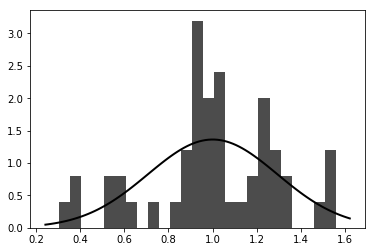

0.9999999999999999 0.2928902947066053


In [5]:
# scaling factors
fig, ax = plt.subplots()
sum_all = np.sum(X, axis=1)

# scalings = sum_all / np.mean(sum_all)
mu, std = norm.fit(scalings)

ax.hist(scalings, bins=25, normed=True, alpha=0.7, color='black', label="all")
# np.savetxt("islam/islam_scalings.txt", scalings)

# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
plt.show()
print(mu, std)

In [6]:
gene_means = np.mean(X, axis=0)
np.savetxt("islam/islam_genes.txt", gene_means)